In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc

df1 = pd.read_excel("labelling_ET_processed.xlsx")[["paper_id", "label"]]
df2 = pd.read_excel("labelling_BB.xlsx")[["paper_id", "label"]]
df3 = pd.read_excel("labelling_PG.xlsx")[["paper_id", "label"]]
df4 = pd.read_excel("labelling_ML.xlsx")[["paper_id", "label", "probability"]]
df_final = pd.read_excel("agreement_aim_review.xlsx")[["paper_id", "label"]]


In [2]:
def compute_metrics(df_reviewer, df_final, name="Reviewer"):
    
    # Merge with ground truth
    df = df_reviewer.merge(df_final, on="paper_id", suffixes=("_pred", "_true"))
    
    y_true = df["label_true"]
    y_pred = df["label_pred"]
    
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # ---- Core Rates ----
    TPR = tp / (tp + fn) if (tp + fn) > 0 else 0          # Sensitivity / Recall
    TNR = tn / (tn + fp) if (tn + fp) > 0 else 0          # Specificity
    FPR = fp / (fp + tn) if (fp + tn) > 0 else 0          # Fall-out
    FNR = fn / (tp + fn) if (tp + fn) > 0 else 0          # Miss rate
    
    PPV = tp / (tp + fp) if (tp + fp) > 0 else 0          # Precision
    NPV = tn / (tn + fn) if (tn + fn) > 0 else 0          # Negative predictive value
    
    # ---- Balanced Accuracy (manual formula) ----
    BAC = 0.5 * (TPR + TNR)
    
    # ---- F1 score (manual formula) ----
    F1 = (2 * PPV * TPR) / (PPV + TPR) if (PPV + TPR) > 0 else 0
    
    # ---- P4 score (harmonic mean of PPV, TPR, TNR, NPV) ----
    if PPV > 0 and TPR > 0 and TNR > 0 and NPV > 0:
        P4 = 4 / ((1/PPV) + (1/TPR) + (1/TNR) + (1/NPV))
    else:
        P4 = 0
    
    
    results = {
        "Reviewer": name,
        "TP": tp,
        "TN": tn,
        "FP": fp,
        "FN": fn,
        "TPR (Sensitivity)": TPR,
        "TNR (Specificity)": TNR,
        "FPR": FPR,
        "FNR": FNR,
        "PPV (Precision)": PPV,
        "NPV": NPV,
        "Balanced Accuracy (BAC)": BAC,
        "F1 Score": F1,
        "P4 Score": P4

    }
    
    return results


# Run for all reviewers
results = []
results.append(compute_metrics(df1, df_final, "df1"))
results.append(compute_metrics(df2, df_final, "df2"))
results.append(compute_metrics(df3, df_final, "df3"))
results.append(compute_metrics(df4, df_final, "df4"))

results_df = pd.DataFrame(results)
results_df.to_excel("performance_metrics.xlsx", index = None)
results_df

,Reviewer,TP,TN,FP,FN,TPR (Sensitivity),TNR (Specificity),FPR,FNR,PPV (Precision),NPV,Balanced Accuracy (BAC),F1 Score,P4 Score
0,df1,28,1051,16,31,0.474576,0.985005,0.014995,0.525424,0.636364,0.971349,0.729790,0.543689,0.698899
1,df2,48,1033,34,11,0.813559,0.968135,0.031865,0.186441,0.585366,0.989464,0.890847,0.680851,0.803042
2,df3,51,1034,33,8,0.864407,0.969072,0.030928,0.135593,0.607143,0.992322,0.916739,0.713287,0.825837
3,df4,45,954,113,14,0.762712,0.894096,0.105904,0.237288,0.284810,0.985537,0.828404,0.414747,0.575097


In [5]:
#Testing multiple thresholds
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# Thresholds to test
thresholds = np.linspace(0,1,101)


df_final_renamed = df_final.rename(columns={"label": "label_true"})
threshold_results = []

for t in thresholds:
    df_thresh = df4.copy()
    # Generate predicted label using threshold
    df_thresh["label_pred"] = (df_thresh["probability"] >= t).astype(int)
    # Only keep paper_id and label_pred
    df_for_metrics = df_thresh[["paper_id", "label_pred"]]
    
    # Compute metrics against df_final_renamed
    metrics = compute_metrics(df_for_metrics, df_final_renamed, name=f"df4_thresh_{t}")
    threshold_results.append(metrics)

# Combine results
threshold_results_df = pd.DataFrame(threshold_results)
threshold_results_df.to_excel("performance_metrics_multiple_thresholds.xlsx", index = None)
threshold_results_df

,Reviewer,TP,TN,FP,FN,TPR (Sensitivity),TNR (Specificity),FPR,FNR,PPV (Precision),NPV,Balanced Accuracy (BAC),F1 Score,P4 Score
0,df4_thresh_0.0,59,0,1067,0,1.000000,0.000000,1.000000,0.000000,0.052398,0.000000,0.500000,0.099578,0.000000
1,df4_thresh_0.01,56,836,231,3,0.949153,0.783505,0.216495,0.050847,0.195122,0.996424,0.866329,0.323699,0.472898
2,df4_thresh_0.02,56,869,198,3,0.949153,0.814433,0.185567,0.050847,0.220472,0.996560,0.881793,0.357827,0.511471
3,df4_thresh_0.03,55,883,184,4,0.932203,0.827554,0.172446,0.067797,0.230126,0.995490,0.879879,0.369128,0.524171
4,df4_thresh_0.04,54,886,181,5,0.915254,0.830366,0.169634,0.084746,0.229787,0.994388,0.872810,0.367347,0.522577
5,df4_thresh_0.05,54,893,174,5,0.915254,0.836926,0.163074,0.084746,0.236842,0.994432,0.876090,0.376307,0.532250
6,df4_thresh_0.06,54,898,169,5,0.915254,0.841612,0.158388,0.084746,0.242152,0.994463,0.878433,0.382979,0.539375
7,df4_thresh_0.07,53,902,165,6,0.898305,0.845361,0.154639,0.101695,0.243119,0.993392,0.871833,0.382671,0.539375
8,df4_thresh_0.08,53,903,164,6,0.898305,0.846298,0.153702,0.101695,0.244240,0.993399,0.872302,0.384058,0.540847
9,df4_thresh_0.09,52,905,162,7,0.881356,0.848172,0.151828,0.118644,0.242991,0.992325,0.864764,0.380952,0.537870


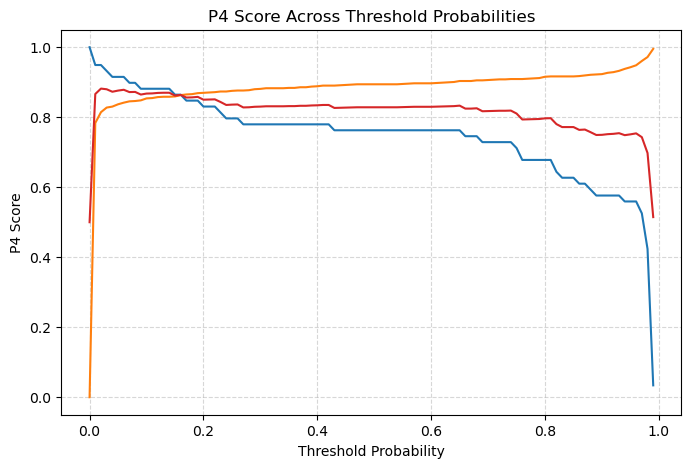

In [15]:
import matplotlib.pyplot as plt

# Extract numeric threshold from Reviewer column
df_thresh = threshold_results_df.copy()
df_thresh['Threshold'] = df_thresh['Reviewer'].str.extract(r'_(0\.\d+)$').astype(float)

# Plot P4 Score vs Threshold
plt.figure(figsize=(8,5))

plt.plot(df_thresh['Threshold'], df_thresh['TPR (Sensitivity)'],  color='tab:blue')
plt.plot(df_thresh['Threshold'], df_thresh['TNR (Specificity)'],  color='tab:orange')
plt.plot(df_thresh['Threshold'], df_thresh['Balanced Accuracy (BAC)'],  color='tab:red')

plt.title("P4 Score Across Threshold Probabilities")
plt.xlabel("Threshold Probability")
plt.ylabel("P4 Score")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()